<a href="https://colab.research.google.com/github/gabillah/optimization/blob/main/NSGA%20II%20-%2004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Memulai Optimasi...
Gen 0: Best BHP Power (Feasible) = 2756.93 kW
Gen 5: Best BHP Power (Feasible) = 2667.62 kW
Gen 10: Best BHP Power (Feasible) = 2543.58 kW
Gen 15: Best BHP Power (Feasible) = 2434.66 kW
Gen 20: Best BHP Power (Feasible) = 2434.66 kW
Gen 25: Best BHP Power (Feasible) = 2410.58 kW
Gen 30: Best BHP Power (Feasible) = 2409.30 kW
Gen 35: Best BHP Power (Feasible) = 2403.64 kW
Gen 40: Best BHP Power (Feasible) = 2374.66 kW
Gen 45: Best BHP Power (Feasible) = 2374.66 kW
Gen 50: Best BHP Power (Feasible) = 2361.99 kW
Gen 55: Best BHP Power (Feasible) = 2361.99 kW

SUKSES: Ditemukan 200 solusi feasible.


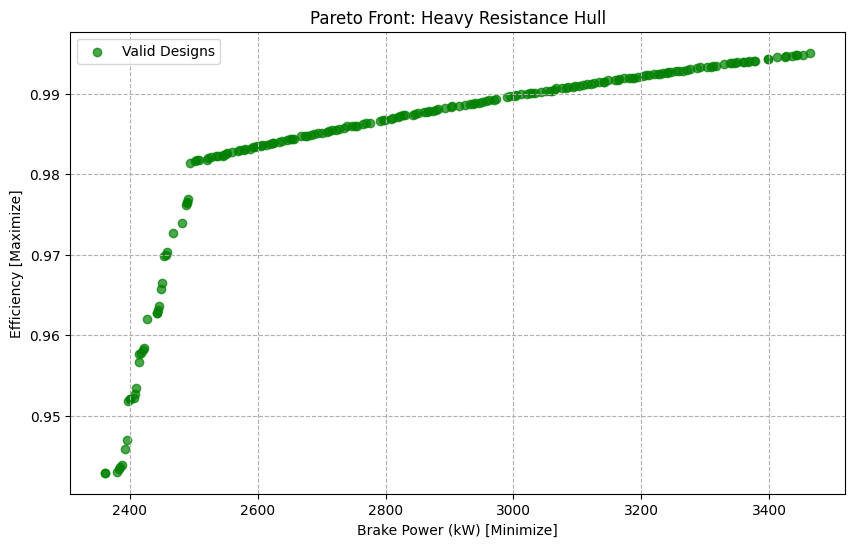

=== DESAIN OPTIMUM ===
P/D       : 1.400
EAR       : 0.450
Blades    : 5
RPM       : 180.1
Speed (Vs): 16.0 knots
--------------------
BHP Power : 3463.59 kW
Eff       : 0.9951


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import math

# ==========================================
# BAGIAN 1: INPUT DATA & PARAMETER TETAP
# ==========================================

# 1. Parameter Lambung & Lingkungan
RHO = 1025.0
D_PROP = 3.0
WAKE_FRAC = 0.15
THRUST_DED = 0.20
GRAVITY = 9.81

# --- FIXED PARAMETER: Tahanan Kapal ---
def get_ship_resistance(v_knots):
    v_ms = v_knots * 0.51444
    # Resistance (N) = 4000 * v^2 (Sangat Berat)
    return 4000.0 * (v_ms ** 2)

# 2. Database Engine & Gearbox (DIPERBARUI - Menambah Engine Besar)
ENGINE_DB = [
    # Engine Kecil
    {"name": "Engine A", "mcr": 1000, "rpm": 750, "gears": [2.0, 3.0, 4.0]},
    {"name": "Engine B", "mcr": 2000, "rpm": 900, "gears": [2.5, 3.5, 4.5]},
    # Engine Besar (Wajib ada untuk R = 4000*V^2)
    {"name": "Engine C (Med)", "mcr": 3500, "rpm": 1000, "gears": [3.0, 3.5, 4.0, 5.0]},
    {"name": "Engine D (Large)", "mcr": 5000, "rpm": 1200, "gears": [3.5, 4.0, 5.0, 6.0]},
    {"name": "Engine E (X-Large)", "mcr": 6500, "rpm": 1500, "gears": [4.0, 5.0, 6.0]}
]

# 3. Rentang Variabel Desain
BOUNDS = [
    [0.5, 1.4],   # P/D
    [0.45, 1.2],  # EAR
    [3, 6],       # Z
    [100, 400],   # RPM Propeller
    [10, 16]      # Vs (Speed)
]

# ==========================================
# BAGIAN 2: MODEL FISIKA & EVALUASI
# ==========================================

class Individual:
    def __init__(self):
        self.genes = []
        self.objectives = []
        self.rank = 0
        self.crowding_distance = 0
        self.constraints_violated = 0

def calculate_propulsion(genes):
    pd, ear, z, rpm, vs_knot = genes
    z = int(round(z))

    n_rps = rpm / 60.0
    vs_ms = vs_knot * 0.51444
    va_ms = vs_ms * (1 - WAKE_FRAC)

    # Hitung J
    J = va_ms / (n_rps * D_PROP)
    if J <= 0: J = 0.001

    # Rumus KT KQ
    kt = 0.55 - 0.4*J + 0.25*pd + 0.08*ear
    kq = 0.06 - 0.04*J + 0.03*pd + 0.015*ear

    kt = max(0.001, kt)
    kq = max(0.001, kq)

    eta_o = (J / (2 * np.pi)) * (kt / kq)

    thrust = kt * RHO * (n_rps**2) * (D_PROP**4)
    torque = kq * RHO * (n_rps**2) * (D_PROP**5)
    power_d = 2 * np.pi * n_rps * torque / 1000.0

    return thrust, power_d, eta_o

def check_constraints(genes, thrust_prod, power_req):
    pd, ear, z, rpm, vs_knot = genes

    # Constraint 1: Thrust vs Resistance
    resistance = get_ship_resistance(vs_knot)
    thrust_req = resistance / (1 - THRUST_DED)

    if thrust_prod < (thrust_req * 0.98):
        return False, 1e6 # Gagal Thrust

    # Constraint 2: Kavitasi
    p_static = 101325 + (RHO * GRAVITY * (2 + D_PROP/2))
    p_vapor = 1700
    min_ear_req = ((1.3 + 0.3*z) * thrust_prod) / ((p_static - p_vapor) * D_PROP**2) * 0.001

    if ear < min_ear_req:
        return False, 1e6 # Gagal Kavitasi

    # Constraint 3: Engine Matching
    match_found = False
    brake_power_req = power_req / 0.95

    for engine in ENGINE_DB:
        if engine["mcr"] >= brake_power_req:
            for ratio in engine["gears"]:
                target_rpm = engine["rpm"] / ratio
                if 0.90 * target_rpm <= rpm <= 1.10 * target_rpm:
                    match_found = True
                    break
        if match_found: break

    if not match_found:
        return False, 1e5 # Gagal Matching

    return True, 0

def evaluate_individual(ind):
    thrust, power, eff = calculate_propulsion(ind.genes)
    is_valid, penalty = check_constraints(ind.genes, thrust, power)

    bhp = (power / 0.95) + penalty
    obj2 = -eff if is_valid else 0

    ind.objectives = [bhp, obj2]
    ind.constraints_violated = penalty

# ==========================================
# BAGIAN 3: ALGORITMA NSGA-II
# ==========================================

def dominates(ind1, ind2):
    and_condition = True
    or_condition = False
    for i in range(len(ind1.objectives)):
        if ind1.objectives[i] > ind2.objectives[i]:
            and_condition = False
        if ind1.objectives[i] < ind2.objectives[i]:
            or_condition = True
    return and_condition and or_condition

def fast_non_dominated_sort(population):
    fronts = [[]]
    for p in population:
        p.domination_count = 0
        p.dominated_solutions = []
        for q in population:
            if dominates(p, q):
                p.dominated_solutions.append(q)
            elif dominates(q, p):
                p.domination_count += 1
        if p.domination_count == 0:
            p.rank = 0
            fronts[0].append(p)
    i = 0
    while len(fronts[i]) > 0:
        next_front = []
        for p in fronts[i]:
            for q in p.dominated_solutions:
                q.domination_count -= 1
                if q.domination_count == 0:
                    q.rank = i + 1
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    return fronts[:-1]

# --- BAGIAN YANG TADI ERROR SUDAH DIPERBAIKI ---
def calculate_crowding_distance(front):
    l = len(front)  # <--- Perbaikan di sini (tutup kurung ditambahkan)
    if l == 0: return
    for ind in front: ind.crowding_distance = 0
    for m in range(len(front[0].objectives)):
        front.sort(key=lambda x: x.objectives[m])
        front[0].crowding_distance = float('inf')
        front[l-1].crowding_distance = float('inf')
        obj_range = front[l-1].objectives[m] - front[0].objectives[m]
        if obj_range == 0: obj_range = 1e-9
        for i in range(1, l-1):
            front[i].crowding_distance += (front[i+1].objectives[m] - front[i-1].objectives[m]) / obj_range

def tournament_selection(pop):
    i, j = random.sample(range(len(pop)), 2)
    ind1, ind2 = pop[i], pop[j]
    if ind1.rank < ind2.rank: return ind1
    elif ind2.rank < ind1.rank: return ind2
    elif ind1.crowding_distance > ind2.crowding_distance: return ind1
    else: return ind2

def crossover(parent1, parent2):
    child = Individual()
    alpha = random.random()
    child.genes = [alpha*g1 + (1-alpha)*g2 for g1, g2 in zip(parent1.genes, parent2.genes)]
    return child

def mutation(ind):
    for i in range(len(ind.genes)):
        if random.random() < 0.2:
            sigma = (BOUNDS[i][1] - BOUNDS[i][0]) * 0.2
            ind.genes[i] += random.gauss(0, sigma)
            ind.genes[i] = max(BOUNDS[i][0], min(BOUNDS[i][1], ind.genes[i]))

def run_nsga2(pop_size=100, max_gen=50):
    population = []
    for _ in range(pop_size):
        ind = Individual()
        ind.genes = [random.uniform(b[0], b[1]) for b in BOUNDS]
        evaluate_individual(ind)
        population.append(ind)

    print("Memulai Optimasi...")
    for gen in range(max_gen):
        fronts = fast_non_dominated_sort(population)
        for front in fronts: calculate_crowding_distance(front)

        offspring = []
        while len(offspring) < pop_size:
            p1 = tournament_selection(population)
            p2 = tournament_selection(population)
            child = crossover(p1, p2)
            mutation(child)
            evaluate_individual(child)
            offspring.append(child)

        combined_pop = population + offspring
        fronts = fast_non_dominated_sort(combined_pop)
        new_population = []
        for front in fronts:
            calculate_crowding_distance(front)
            front.sort(key=lambda x: x.crowding_distance, reverse=True)
            for ind in front:
                if len(new_population) < pop_size: new_population.append(ind)
                else: break
        population = new_population

        if gen % 5 == 0:
            valid_ind = [ind for ind in population if ind.constraints_violated == 0]
            if valid_ind:
                best_pwr = min([ind.objectives[0] for ind in valid_ind])
                print(f"Gen {gen}: Best BHP Power (Feasible) = {best_pwr:.2f} kW")
            else:
                print(f"Gen {gen}: Mencari solusi feasible...")

    return population

# ==========================================
# EKSEKUSI
# ==========================================
final_pop = run_nsga2(pop_size=200, max_gen=60)

feasible_pop = [ind for ind in final_pop if ind.constraints_violated == 0]

if not feasible_pop:
    print("\nGAGAL. Solusi tidak ditemukan.")
else:
    print(f"\nSUKSES: Ditemukan {len(feasible_pop)} solusi feasible.")

    powers = [ind.objectives[0] for ind in feasible_pop]
    effs = [-ind.objectives[1] for ind in feasible_pop]

    plt.figure(figsize=(10, 6))
    plt.scatter(powers, effs, c='green', alpha=0.7, label='Valid Designs')
    plt.xlabel('Brake Power (kW) [Minimize]')
    plt.ylabel('Efficiency [Maximize]')
    plt.title('Pareto Front: Heavy Resistance Hull')
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.show()

    best_ind = max(feasible_pop, key=lambda x: -x.objectives[1])

    print("=== DESAIN OPTIMUM ===")
    print(f"P/D       : {best_ind.genes[0]:.3f}")
    print(f"EAR       : {best_ind.genes[1]:.3f}")
    print(f"Blades    : {int(round(best_ind.genes[2]))}")
    print(f"RPM       : {best_ind.genes[3]:.1f}")
    print(f"Speed (Vs): {best_ind.genes[4]:.1f} knots")
    print("-" * 20)
    print(f"BHP Power : {best_ind.objectives[0]:.2f} kW")
    print(f"Eff       : {-best_ind.objectives[1]:.4f}")